# Sistema de recomendação de filmes

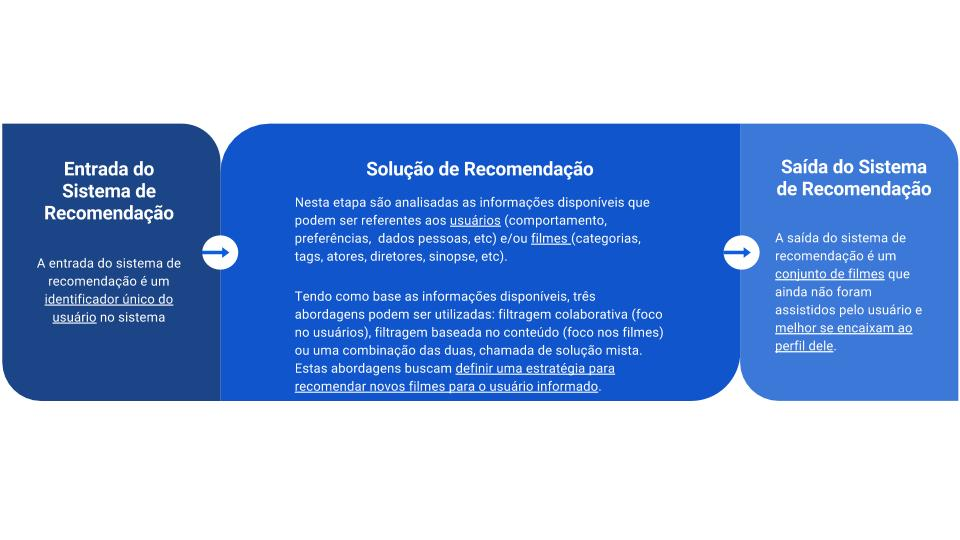

In [12]:
from IPython.display import Image
Image(filename='Overview_do_Problema.jpg', width=900)

Este projeto tem como objetivo principal a construção de um sistema de recomendação para o conjunto de filmes e ratings do dataset [ml-latest-small](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip).

Este projeto está dividido em duas etapas principais:
    - Exploração dos dados
    - Sistema de recomendação

A primeira etapa tem como objetivo extrair informações do dataset, verificar consistência dos dados e buscar insights que podem contribuir para a construção do sistema de recomendação. Já a segunda etapa consiste na construção do sistema de recomendação com base nas premissas extraídas da primeira etapa.

## Pacotes requeridos

In [38]:
# Pacotes importantes para este projeto
import numpy as np
import pandas as pd
from pandas import Series
from time import time
# Pacotes para exibição dos gráficos e imagens
import seaborn as sns
import matplotlib.pyplot as plt
# Pacote para inferência de ratings em sistemas de recomendação
from surprise import SVDpp
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
# Barra de progresso
from tqdm import tqdm

%matplotlib inline

!pip freeze > requirements.txt

## Carregando o dataset

O dataset é composto de 9125 filmes organizados com:
    - id;
    - título;
    - gênero. 
    
Os gêneros dos filmes são representados por uma composição como: aventura|ação|fantasia

In [2]:
# Leitura do dataset
dfMovies = pd.read_csv("./ml-latest-small/movies.csv")
dfRatings = pd.read_csv("./ml-latest-small/ratings.csv")
dfTags = pd.read_csv("./ml-latest-small/tags.csv")
dfLinks = pd.read_csv("./ml-latest-small/links.csv")

print("\n\nFilmes:")
print(dfMovies.head())
print("Número de filmes no dataset: {}".format(len(dfMovies)))

print("\n\nRatings:")
print(dfRatings.head())
print("Número de ratings no dataset: {}".format(len(dfRatings)))

print("\n\nTags:")
print(dfTags.head())
print("Número de tags no dataset: {}".format(len(dfTags)))

print("\n\nLinks:")
print(dfLinks.head())
print("Número de links no dataset: {}".format(len(dfLinks)))



Filmes:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
Número de filmes no dataset: 9125


Ratings:
   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
Número de ratings no dataset: 100004


Tags:
   userId  movieId                      tag   timestamp
0      15      

# Exploração dos dados

## Pré-processamento

#### Nesta etapa são mesclados os dados dos ratings com os respectivos filmes e obtendo no final um único Dataframe

In [3]:
# Faz o merge do dataset utilizando os id's dos filmes como chave
dfMoviesRatings = pd.merge(dfMovies, dfRatings, on=['movieId'])
dfMoviesRatings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1331380058
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0,997938310
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0,855190091


#### Nesta etapa são removidas as colunas "timestamp" e "title" que não serão utilizadas para a contrução do sistema de recomendação.

In [4]:
# Remove colunas que não serão utilizadas no treinamento do sistema de recomendação
dfMoviesRatings = dfMoviesRatings.drop(['timestamp', 'title'], 1)
dfMoviesRatings.head()

,movieId,genres,userId,rating
0,1,Adventure|Animation|Children|Comedy|Fantasy,7,3.0
1,1,Adventure|Animation|Children|Comedy|Fantasy,9,4.0
2,1,Adventure|Animation|Children|Comedy|Fantasy,13,5.0
3,1,Adventure|Animation|Children|Comedy|Fantasy,15,2.0
4,1,Adventure|Animation|Children|Comedy|Fantasy,19,3.0


#### Dados nulos ou faltantes

Nesta próxima célula estou verificando se existe algum valor nulo no dataset. Como podemos observar, somente os links possuem algum valor nulo. Por enquanto, estes dados não serão utilizados no desenvolvimento do sistema de recomendação.

In [5]:
print("Movies - Null values: {}".format(dfMovies.isnull().any().any()))
print("Ratings - Null values: {}".format(dfRatings.isnull().any().any()))
print("Tags - Null values: {}".format(dfTags.isnull().any().any()))
print("Links - Null values: {}".format(dfLinks.isnull().any().any()))

Movies - Null values: False
Ratings - Null values: False
Tags - Null values: False
Links - Null values: True


#### Análise e processamento das categorias

Nesta próxima célula eu estou verificando quais categorias estão presentes no datatset. Para isso, eu expandi a coluna gênero separando cada uma das categorias que compõe cada gênero (linha 2 da célula abaixo). Por exemplo, uma categoria com é composta por [Adventure|Animation|Children] passa a ser [Adventure], [Animation], [Children].

In [6]:
# Encontra todas as categorias presentes no dataset
dfCategories = dfMoviesRatings.genres.str.split(pat="|", expand=True)
dfCategories = Series(dfCategories.values.ravel()).unique()
dfCategories

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', None,
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'Documentary', 'IMAX', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

Utilizando o resultado da célula anterior, cada categorias é então incluída no Dataframe como uma nova coluna. Em outras palavras, cada categoria será considerada uma feature individualmente.

In [7]:
# Insere as colunas de cada categoria  
for i in tqdm(range(len(dfCategories))):
    col = dfCategories[i]
    dfMoviesRatings.insert(loc= len(dfMoviesRatings.columns), column=col, value=0)
dfMoviesRatings.head()

100%|██████████| 21/21 [00:00<00:00, 914.53it/s]


,movieId,genres,userId,rating,Adventure,Animation,Children,Comedy,Fantasy,None,...,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Adventure|Animation|Children|Comedy|Fantasy,7,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Adventure|Animation|Children|Comedy|Fantasy,9,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Adventure|Animation|Children|Comedy|Fantasy,13,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Adventure|Animation|Children|Comedy|Fantasy,15,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Adventure|Animation|Children|Comedy|Fantasy,19,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Acrescentadas as colunas referentes a cada uma das categorias, serão definidas como 1 as categorias que compõe o gênero de cada filme.

In [8]:
# Transforma cada categoria em uma feature
for i, row in dfMoviesRatings.iterrows():
    dfMoviesRatings.set_value(col=row[1].split(sep="|"), index=i, value=1)

dfMoviesRatings.head()

,movieId,genres,userId,rating,Adventure,Animation,Children,Comedy,Fantasy,None,...,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Adventure|Animation|Children|Comedy|Fantasy,7,3.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Adventure|Animation|Children|Comedy|Fantasy,9,4.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Adventure|Animation|Children|Comedy|Fantasy,15,2.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Adventure|Animation|Children|Comedy|Fantasy,19,3.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


Nesta célula estou removendo as colunas "None" e "(no genres listed)" que não correspondem às categorias de filmes. 

In [9]:
# Remove as categorias: None, '(no genres listed)'
dfMoviesRatings = dfMoviesRatings.drop([None, '(no genres listed)','genres'], 1)

#### Análise e processamentos dos ratings

Nesta etapa estou analisando como os ratings estão distribuídos entre os filmes. Como é possível observar nas células a seguir, esta distribuição não é uniforme. A média por filme é de 11 ratings, podendo chegar a 341 ratings para um único filme. Uma caraterística revelante é que muitos filmes apresentam um único rating. Dentro da minha análise, considero que isso não seja algo positivo para o desenvolvimento do sistem de recomendação. Nestes casos temos muito pouca informação sobre o filme. 

A célula a seguir apresenta a distribuição de ratings por filme e as estatísticas.

Estatísticas:


count    9066.000000
mean       11.030664
std        24.050800
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       341.000000
dtype: float64

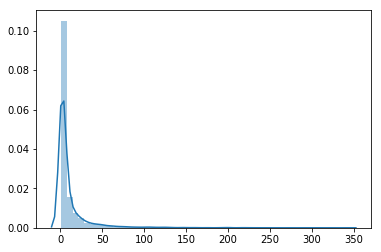

In [10]:
# Verifica o número de avaliações por filme
number_of_ratings_per_movie = pd.value_counts(dfMoviesRatings['movieId'].values, sort=False)

# Apresenta o gráfico com a distribuição o número de avaliações por filme
sns.distplot(pd.Series(number_of_ratings_per_movie, name=""))

# Algumas estatísticas
print('Estatísticas:')
number_of_ratings_per_movie.describe()

A célula a seguir apresenta os dados após a remoção de 10% dos filmes com o menor número de rating.

Estatísticas:


count    6003.000000
mean       16.148759
std        28.215085
min         2.000000
25%         3.000000
50%         6.000000
75%        16.000000
max       341.000000
Name: 0, dtype: float64

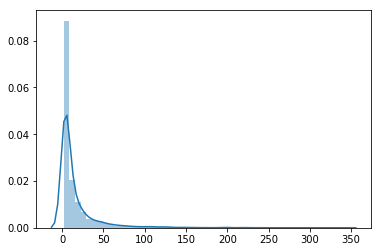

In [11]:
# Retirando 10% dos filmes que apresentam muito menos ratings que os demais 90%
new_data = number_of_ratings_per_movie.to_frame()[number_of_ratings_per_movie > 
                                                  number_of_ratings_per_movie.quantile(0.10)]

sns.distplot(pd.Series(new_data[0], name=""))

# Algumas estatísticas
print('Estatísticas:')
new_data[0].describe()


A seguir são removidos os filmes que apresentam um número de ratings muito menor que os demais. Isso se deve ao fato de que as avaliações destes filmes são pouco expressivas diante dos demais filmes. O método para inferência de ratings teria dificuldade para generalizar tendo tão poucas amostras.

Na célula a seguir o número de ratings é incluído como uma nova feature no dataset e reescalado para ficar no intervalo (0, 1).

In [12]:
new_data["movieId"] = new_data.index
dfMoviesRatingsFinal = pd.merge(dfMoviesRatings, new_data, how='inner', on=['movieId'])
dfMoviesRatingsFinal = dfMoviesRatingsFinal.rename(columns={0: 'NumberRatings'})
# Reescala o número de ratings entre (0,1)
dfMoviesRatingsFinal.NumberRatings = dfMoviesRatingsFinal.NumberRatings/dfMoviesRatingsFinal.NumberRatings.max()
dfMoviesRatingsFinal.head()

,movieId,userId,rating,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir,NumberRatings
0,1,7,3.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.72434
1,1,9,4.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.72434
2,1,13,5.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.72434
3,1,15,2.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.72434
4,1,19,3.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.72434


Na célula a seguir os ratings são reescalados para o intervalo (0,10). Este processamento visa melhorar o desempenho do método de inferência de ratings.

In [13]:
# Reescala os ratings entre (0,10)
dfMoviesRatingsFinal.rating = dfMoviesRatingsFinal.rating*2
dfMoviesRatingsFinal.head()

,movieId,userId,rating,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir,NumberRatings
0,1,7,6.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.72434
1,1,9,8.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.72434
2,1,13,10.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.72434
3,1,15,4.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.72434
4,1,19,6.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.72434


## Conclusões

### Existe alguma relação entre a categoria do filme e a forma que ele é avaliado?

Para avaliar se existe relação entre o rating e as categorias de filmes foi calculada a matriz de correlação, através da função ```corr()``` do pacote Pandas (linha 4). Além disso, foram apresentadas somente as correlações associadas ao rating (linha 7). Foi utilizada uma tabela de cores para facilitar a visualização dos dados. As cores mais próximas do vermelho ou azul apresentam correlações positivas ou negativas, respectivamente. Já as cores mais próximas do cinza apresentam baixa correlação.

O gráfico abaixo mostra que somente algumas categorias estão relacionadas com os ratings como, por exemplo, comédia, drama e ação. 

,rating,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir
rating,1.000000,-0.015342,0.021598,-0.024316,-0.074266,-0.009649,0.004054,0.119464,-0.059538,0.057622,-0.013991,-0.054505,0.036973,-0.036404,0.033363,0.003523,0.060050,0.011775,0.002778,0.043014
Adventure,-0.015342,1.000000,0.236263,0.234940,-0.065284,0.250888,-0.150553,-0.270223,0.332723,-0.175636,-0.038294,-0.104575,-0.089927,0.250763,-0.058928,0.166545,-0.052454,0.017686,0.045599,-0.045320
Animation,0.021598,0.236263,1.000000,0.662864,0.089702,0.248662,-0.013580,-0.141294,-0.099091,-0.079586,-0.144603,-0.060133,-0.049555,-0.033108,-0.028548,0.108699,-0.051558,0.348446,-0.029069,-0.027402
Children,-0.024316,0.234940,0.662864,1.000000,0.107454,0.328427,-0.045134,-0.152283,-0.143431,-0.113842,-0.180850,-0.081959,-0.062010,-0.063775,-0.034376,0.082379,-0.068539,0.335119,-0.033568,-0.033095
Comedy,-0.074266,-0.065284,0.089702,0.107454,1.000000,0.070861,0.191030,-0.273576,-0.232926,-0.087594,-0.326531,-0.105668,-0.170198,-0.174390,-0.064401,-0.111778,-0.075394,0.050828,-0.025703,-0.079823
Fantasy,-0.009649,0.250888,0.248662,0.328427,0.070861,1.000000,0.032998,-0.156257,-0.027846,-0.116033,-0.135567,0.004390,-0.031985,-0.074670,-0.040077,0.108151,-0.067167,0.129073,-0.046944,-0.030785
Romance,0.004054,-0.150553,-0.013580,-0.045134,0.191030,0.032998,1.000000,0.104883,-0.176180,-0.168840,-0.167281,-0.112594,-0.065263,-0.165873,-0.057436,-0.053382,0.017336,0.080124,-0.023485,-0.027680
Drama,0.119464,-0.270223,-0.141294,-0.152283,-0.273576,-0.156257,0.104883,1.000000,-0.249450,0.061960,-0.074646,-0.132573,0.002010,-0.204354,-0.088665,-0.059938,0.179425,-0.074126,-0.005557,-0.013944
Action,-0.059538,0.332723,-0.099091,-0.143431,-0.232926,-0.027846,-0.176180,-0.249450,1.000000,0.098307,0.276345,-0.031543,-0.048879,0.330955,-0.068329,0.129261,0.059774,-0.122630,0.028211,-0.047656
Crime,0.057622,-0.175636,-0.079586,-0.113842,-0.087594,-0.116033,-0.168840,0.061960,0.098307,1.000000,0.294383,-0.042280,0.135813,-0.134644,-0.050388,-0.015724,-0.080754,-0.090299,-0.051060,0.152329


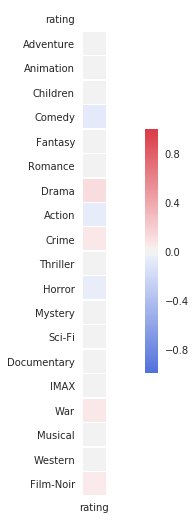

In [14]:
sns.set(style="white")

# Calcula a matriz de correlação das categorias
corr = dfMoviesRatingsFinal.drop(['movieId', 'NumberRatings','userId'],1).corr()

# Gera uma máscara para a parte superior do triângulo
corrRating = corr[['rating']]
mask = np.zeros_like(corrRating, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Define a area de render do gráfico
f, ax = plt.subplots(figsize=(14, 9))

# Gera o colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Deseja o mapa de calor com a correlação entre as categorias
sns.heatmap(corrRating, mask=mask, cmap=cmap, vmax=1., vmin=-1.,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr

### Quais são as categorias que possuem relação entre si?
Para verificar a relação entre as categorias é calculado a matriz de correlação, como apresentado na linha 4 da célula a seguir.
    
Existe uma grande correlação entre algumas categorias, como podemos observar na matriz de correlação apresentada abaixo. Podemos citar como exemplo o fato dos filmes de animação estarem relacionados a filmes infantis (correlação de 0.66). Esta correlação faz sentido visto que a grande maioria dos filmes de animação são direcionados ao público infantil. A mesma análise pode ser feita para categorias com correlação negativa. Neste contexto, podemos citar que os gêneros comédia e suspense não coexistem. Da mesma que filmes de suspense e musicais ou animações.

Já alguns gêneros, como documentário e musical, tem correlação muito próxima de zero estando pouco relacionados.

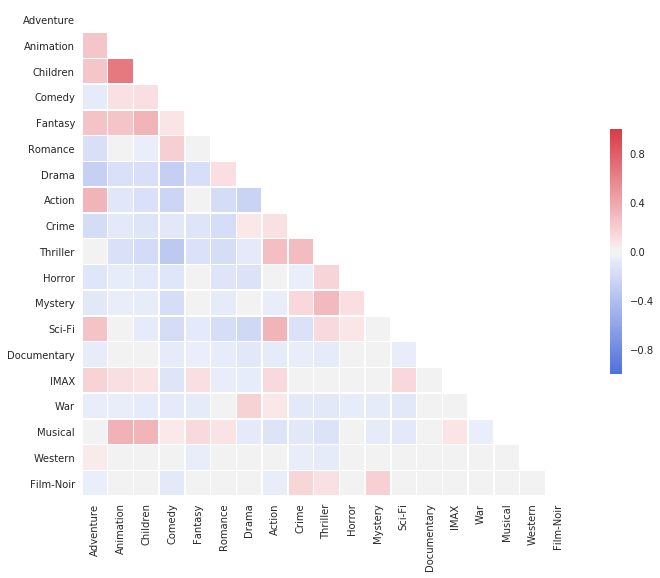

In [15]:
sns.set(style="white")

# Calcula a matriz de correlação das categorias
corr = dfMoviesRatingsFinal.drop(['movieId', 'rating', 'NumberRatings', 'userId'],1).corr()

# Gera uma máscara para a parte superior do triângulo
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Define a area de render do gráfico
f, ax = plt.subplots(figsize=(14, 9))

# Gera o colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Deseja o mapa de calor com a correlação entre as categorias
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., vmin=-1.,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

A seguir são apresentadas as correlações entre as categorias dos filmes com os respectivos valores.

In [16]:
# Filmes com maior correlação
print("Filmes com correlação POSITIVA")
dfMax = corr[ corr[:] == np.max(corr[corr[:] != 1]) ]
for row in corr:
    # Categoria corrente
    currentCategoryName = corr.columns[corr.columns == row][0]
    # Categoria com a maior correlação 
    correlatedCategory = dfMax[row].dropna().index[0]
    # Correlação
    correlation = dfMax[row].dropna()[0]
    # Imprimi as maiores correlações entre as categorias
    print("{}: \t\t{} com valor de {}".format(currentCategoryName, correlatedCategory, 
                                                                                 str(correlation)))
print("\n\nFilmes com correlação NEGATIVA")
dfMin = corr[ corr[:] == np.min(corr[corr[:] != 1]) ]
for row in corr:
    # Categoria corrente
    currentCategoryName = corr.columns[corr.columns == row][0]
    # Categoria com a maior correlação 
    correlatedCategory = dfMin[row].dropna().index[0]
    # Correlação
    correlation = dfMin[row].dropna()[0]
    # Imprimi as maiores correlações entre as categorias
    print("{}: \t\t{} com valor de {}".format(currentCategoryName, correlatedCategory, 
                                                                                 str(correlation)))    
print("\n\nFilmes com menor correlação")
dfMin = corr[ abs(corr[:]) == np.min(abs(corr[corr[:] != 1]))]
for row in corr:
    # Categoria corrente
    currentCategoryName = corr.columns[corr.columns == row][0]
    # Categoria com a maior correlação 
    correlatedCategory = dfMin[row].dropna().index[0]
    # Correlação
    correlation = dfMin[row].dropna()[0]
    # Imprimi as maiores correlações entre as categorias
    print("{}: \t\t{} com valor de {}".format(currentCategoryName, correlatedCategory, 
                                                                                 str(correlation))) 

Filmes com correlação POSITIVA
Adventure: 		Action com valor de 0.332723431776
Animation: 		Children com valor de 0.662864071164
Children: 		Animation com valor de 0.662864071164
Comedy: 		Romance com valor de 0.191030418832
Fantasy: 		Children com valor de 0.328426912352
Romance: 		Comedy com valor de 0.191030418832
Drama: 		War com valor de 0.179425296022
Action: 		Adventure com valor de 0.332723431776
Crime: 		Thriller com valor de 0.29438304869
Thriller: 		Mystery com valor de 0.304666598599
Horror: 		Thriller com valor de 0.161727513047
Mystery: 		Thriller com valor de 0.304666598599
Sci-Fi: 		Action com valor de 0.33095518977
Documentary: 		Musical com valor de 0.000541737000988
IMAX: 		Adventure com valor de 0.166544564629
War: 		Drama com valor de 0.179425296022
Musical: 		Animation com valor de 0.348446210734
Western: 		Adventure com valor de 0.0455986505598
Film-Noir: 		Mystery com valor de 0.184554410639


Filmes com correlação NEGATIVA
Adventure: 		Drama com valor de -0.270

# Sistema de Recomendação

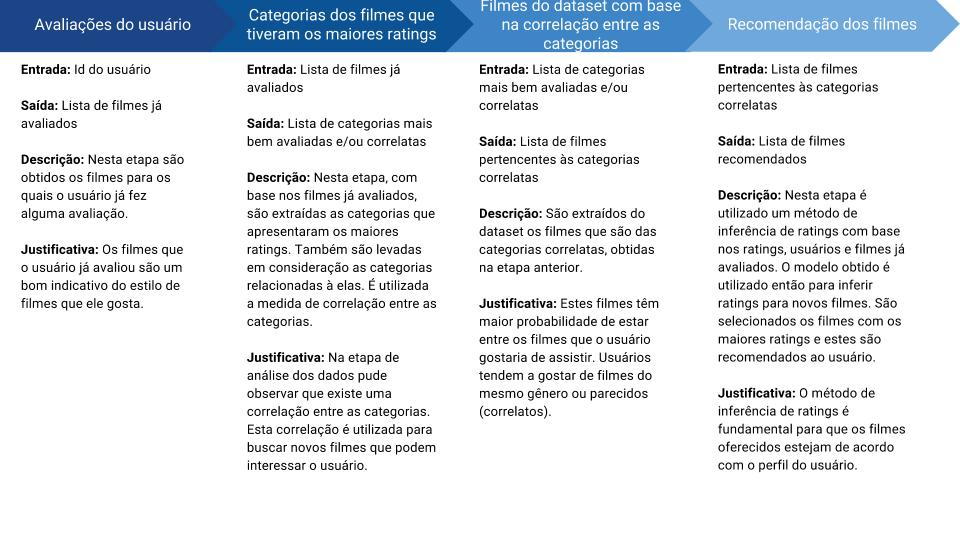

In [17]:
Image(filename='Overview _Sistema _Recomendação.jpg')

## Avaliações do usuário

__Entrada__: Id do usuário

__Saída__: Lista de filmes já avaliados

__Descrição__: Nesta etapa são obtidos os filmes para os quais o usuário já fez alguma avaliação.

__Justificativa__: Os filmes que o usuário já avaliou são um bom indicativo do estilo de filmes que ele gosta.

In [18]:
# Função que retorna os filmes para os quais um usuário já deu rating.
# Retorna um Dataframe com (movieId, rating, userId)
def getUserMovies(userId):
    user_movies = dfMoviesRatingsFinal.userId == userId
    return dfMoviesRatingsFinal[user_movies][['movieId', 'rating']].sort_values(by=['rating'], ascending=False)

In [19]:
idUsertest = 6
usersMovies = getUserMovies(idUsertest)

In [20]:
# Preview do dataframe retornado na função
usersMovies.head()

,movieId,rating
8510,293,10.0
75865,5952,10.0
79919,7153,10.0
29140,1204,10.0
82767,8874,9.0


## Categorias dos filmes que tiveram os maiores ratings

__Entrada__: Lista de filmes já avaliados

__Saída__: Lista de categorias mais bem avaliadas e/ou correlatas

__Descrição__: Nesta etapa, com base nos filmes já avaliados, são extraídas as categorias que apresentaram os maiores ratings. Também são levadas em consideração as categorias relacionadas à elas. É utilizada a medida de correlação entre as categorias.

__Justificativa__: Na etapa de análise dos dados pude observar que existe uma correlação entre as categorias. Esta correlação é utilizada para buscar novos filmes que podem interessar o usuário.

In [21]:
# Função recebe um vetor com os ids dos filmes
# Retorna uma lista com as categorias dos filmes passados
def getCategories(moviesId):
    # Obtem as categorias com os maiores ratings
    uniqueCategories = []
    for idMov in moviesId:
        cat = dfMovies[dfMovies.movieId == idMov].genres
        categories = cat.str.split(pat="|", expand=True).values
        for categorie in categories[0]:
            uniqueCategories.append(categorie)
        
    return np.unique(uniqueCategories)

In [22]:
# Função que retorna as categorias dos maiores e menores ratings dados pelo usuário
# Retorna a lista das categorias para ass quais o usuário deu o maior rating
def getBestCategories(usersMovies):
    # Obtem maior e menor rating dado pelo usuário
    maxRating = np.max(usersMovies.rating.values)
    minRating = np.min(usersMovies.rating.values)
    
    # Ids dos filmes com os maiores ratings
    hightestRatingIds = usersMovies[usersMovies.rating == maxRating].movieId.values
    # Categorias com os maiores ratings
    highestRatingCategories = getCategories(hightestRatingIds)

    # Ids dos filmes com os menores ratings
    lowestRatingIds = usersMovies[usersMovies.rating == minRating].movieId.values
    # Categorias com os menores ratings
    lowestRatingCategories = getCategories(lowestRatingIds)

    # Obtem as categorias com o maior rating, excluindo as categorias que aparecem entre os menores ratings
    categories = list(set(highestRatingCategories) - set(lowestRatingCategories))

    return categories

In [23]:
bestCategories = getBestCategories(usersMovies)

In [24]:
bestCategories

['War', 'Adventure', 'Action', 'Fantasy', 'Crime']

## Filmes do dataset com base na correlação entre as categorias

__Entrada__: Lista de categorias mais bem avaliadas e/ou correlatas

__Saída__: Lista de filmes pertencentes às categorias correlatas

__Descrição__: São extraídos do dataset os filmes que são das categorias correlatas, obtidas na etapa anterior.

__Justificativa__: Estes filmes têm maior probabilidade de estar entre os filmes que o usuário gostaria de assistir. Usuários tendem a gostar de filmes do mesmo gênero ou parecidos (correlatos).


#### Extrai a correlação entre as categorias

In [25]:
# Função que busca as categorias com as maiores e menores correlações
# Retorna duas listas ordenadas com: (categoria, categoria correlata, medida de correlação)
def getMostCorrelatedCategories(bestCategories):
    # Calcula a matriz de correlação entre as categorias
    corr = dfMoviesRatingsFinal.drop(['movieId', 'rating', 'NumberRatings', 'userId'],1).corr()
    corr[corr == 1] = None
    dfMoviesRatingsFinal
    
    # Obtem as colunas referentes as categorias
    bestCategoriesColumns = corr[bestCategories]
    # Busca as maiores correlações entre as categorias
    mostCorrelatedCategories = []
    for col in bestCategories:
        mostCorrelatedCategories.append([col, bestCategoriesColumns[col].idxmax(), 
                                         bestCategoriesColumns[col].max()])
    # Busca as maiores correlações entre as categorias
    lessCorrelatedCategories = []
    for col in bestCategories:
        lessCorrelatedCategories.append([col, bestCategoriesColumns[col].idxmin(), 
                                         bestCategoriesColumns[col].min()])
    # Ordena o resultado
    mostCorrelatedCategories = sorted(mostCorrelatedCategories, key=lambda tup: abs(tup[2]), reverse=True) 
    lessCorrelatedCategories = sorted(lessCorrelatedCategories, key=lambda tup: abs(tup[2]), reverse=True) 
    
    return mostCorrelatedCategories, lessCorrelatedCategories

In [26]:
mostCorrelatedCategories, lessCorrelatedCategories = getMostCorrelatedCategories(bestCategories)

In [27]:
print("Categorias com as maiores correlações: {}".format(mostCorrelatedCategories))
print("\nCategorias com as menores correlações: {}".format(lessCorrelatedCategories))

Categorias com as maiores correlações: [['Adventure', 'Action', 0.3327234317761531], ['Action', 'Adventure', 0.3327234317761531], ['Fantasy', 'Children', 0.32842691235204413], ['Crime', 'Thriller', 0.29438304868953202], ['War', 'Drama', 0.17942529602249774]]

Categorias com as menores correlações: [['Adventure', 'Drama', -0.27022273140736541], ['Action', 'Drama', -0.24945009079411273], ['Crime', 'Adventure', -0.17563640255880617], ['Fantasy', 'Drama', -0.15625741703470586], ['War', 'Thriller', -0.086966290845840774]]


#### Extrai o conjunto de filmes com base nas correlações entre as categorias

In [28]:
# Função que recebe duas listas com as categorias mais correlacionadas e a menos correlacionadas
# Retorna uma lista de filmes extraídos do dataset  
def getListOfMovies(mostCorrelatedCategories, lessCorrelatedCategories):
    # Para cada par de categorias correlacionadas
    listMovies = []
    for corrCategories in mostCorrelatedCategories:
        catA = corrCategories[0]
        catB = corrCategories[1]
        if( len(listMovies) == 0 ):
            a = np.unique(dfMoviesRatingsFinal[dfMoviesRatingsFinal[catA] == 1].movieId.values)
            b = np.unique(dfMoviesRatingsFinal[dfMoviesRatingsFinal[catB] == 1].movieId.values)
            listMovies = np.intersect1d(a, b)
        else:
            b = np.unique(dfMoviesRatingsFinal[dfMoviesRatingsFinal[catB] == 1].movieId.values)
            # Previne que a função retorne menos de 100 filmes para um determinado usuário
            if(len(np.intersect1d(listMovies, b)) < 250):
                break;
            else:
                listMovies = np.intersect1d(listMovies, b)
    
    # Remove os filmes das categorias com as correlações negativas
    for corrCategories in lessCorrelatedCategories:
        catB = corrCategories[1]

        b = np.unique(dfMoviesRatingsFinal[dfMoviesRatingsFinal[catB] == 1].movieId.values)
        # Previne que a função retorne menos de 250 filmes para um determinado usuário
        if(len(set(listMovies) - set(b)) < 250):
            continue;
        else:
            listMovies = set(listMovies) - set(b)  
    
    return listMovies

In [29]:
listOfMovies = getListOfMovies(mostCorrelatedCategories, lessCorrelatedCategories)

In [30]:
print("Foram selecionados {} filmes".format(len(listOfMovies)))

Foram selecionados 338 filmes


## Recomendação dos Filmes

__Entrada__: Lista de filmes pertencentes às categorias correlatas

__Saída__: Lista de filmes recomendados

__Descrição__: Nesta etapa é utilizado um método de inferência de ratings com base nos ratings, usuários e filmes já avaliados. O modelo obtido é utilizado então para inferir ratings para novos filmes. São selecionados os filmes com os maiores ratings e estes são recomendados ao usuário.

__Justificativa__: O método de inferência de ratings é fundamental para que os filmes oferecidos estejam de acordo com o perfil do usuário.

#### Extrai as features dos filmes selecionados

In [31]:
# Função recebe o dataset de entrada e os filmes selecionados na etapa anterior
# Retorna somente as features dos filmes selecionados
def getMoviesFeatures(df, movies):
    df = df.drop(['userId'],1).groupby(['movieId']).mean()
    return df.loc[movies, : ]

In [32]:
moviesFeatures = getMoviesFeatures(dfMoviesRatingsFinal, listOfMovies)

In [33]:
moviesFeatures.head()

,rating,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir,NumberRatings
movieId,,,,,,,,,,,,,,,,,,,,,
122882,7.580645,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0.090909
122886,7.034483,1,0,0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0.085044
6664,7.000000,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.014663
1544,5.776119,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0.196481
122890,8.000000,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.008798


#### Utiliza um modelo para inferir o rating com base no (userId, movieId)

A avaliação método Single-value decomposition (SVD) é feita através das medidas de erro:
    - root-mean-square error (RMSE):

$$RMSE = \sqrt{\frac{1}{n}\sum^{n}_{j=1}(y_j - {y^*}_j)²}$$
onde:
- número de elementos: $$n$$
- valor observado: $$y_j$$
- valor estimado: $${y^*}_j$$

    - Mean Absolute Error (MAE):

$$MAE = \frac{1}{n} \sum^{n}_{j=1} \left | (y_j - {y^*}_j \right |$$
onde:
- número de elementos: $$n$$
- valor observado: $$y_j$$
- valor estimado: $${y^*}_j$$

In [39]:
# Função que recebe o dataset de treinamento do modelo de inferência de ratings
# Treina o modelo com base no método SVD
# Retorna o modelo treinado
def buildModel_SVD(df):
    # Lê o dataset no formato do pacote Surprise a partir de um DataFrame (Pandas)
    reader = Reader(rating_scale=(0, 10))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    # Divide os dados em treino e teste
    trainset, testset = train_test_split(data, test_size=.25)
    
    # Single-value decomposition
    # O random_state foi setado para facilitar a reprodutibilidade durante os testes, 
    # mas deve ser removido em produção.
    algo = SVD(n_epochs=7, random_state=42)
    # Treinamento do método 
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Calcula as medida de erro para o modelo encontrado
    accuracy.rmse(predictions, verbose=True)
    accuracy.mae(predictions, verbose=True)
    
    return algo

In [40]:
model = buildModel_SVD(dfMoviesRatingsFinal)

RMSE: 1.8082
MAE:  1.3957


Na célula abaixo estou experimentando uma variação do método SVD chamada SVD++. Esta variação do método SVD leva em consideração ratings implícitos. Este método apresenta um tempo de treinamento maior que o SVD. Por outro lado, apresenta um desempenho melhor, como pode ser observado nas medidas de erro RMSE e MAE.

In [41]:
# Função que recebe o dataset de treinamento do modelo de inferência de ratings
# Treina o modelo com base no método SVD
# Retorna o modelo treinado
def buildModel_SVDPP(df):
    # Lê o dataset no formato do pacote Surprise a partir de um DataFrame (Pandas)
    reader = Reader(rating_scale=(0, 10))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    # Divide os dados em treino e teste
    trainset, testset = train_test_split(data, test_size=.25)
    
    # Single-value decomposition
    # O random_state foi setado para facilitar a reprodutibilidade durante os testes, 
    # mas deve ser removido em produção.
    algo = SVDpp(n_epochs=8, random_state=42)
    # Treinamento do método 
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Calcula as medida de erro para o modelo encontrado
    accuracy.rmse(predictions, verbose=True)
    accuracy.mae(predictions, verbose=True)
    
    return algo

In [42]:
model = buildModel_SVDPP(dfMoviesRatingsFinal)

RMSE: 1.7787
MAE:  1.3580


#### Faz inferência para obter as ratings do conjunto dos filmes selecionados

In [43]:
# Função que recebe o id do usuário, o modelo treinado para inferir os ratings e as features dos filmes
# Retorna o conjunto de ids dos filmes com os respectivos ratings
def predictRatings(userId, model, features):
    # Dicionário com os ids dos filmes e os respectivos ratings
    predictions = {'movieId': [], 'rating': []}
    # Para filme selecionado faz a inferência do rating de acordo com o usuário
    for movieId in features.index.values:
        prediction = model.predict(uid=idUsertest, iid=movieId)
        predictions['movieId'].append(movieId)
        predictions['rating'].append(prediction[3])

    return predictions

In [44]:
predictions = predictRatings(idUsertest, model, moviesFeatures)

#### Seleciona somente os filmes que tiveram oos maiores ratings

In [45]:
def getMovies(pred, rating):
    df = pd.DataFrame.from_dict(pred)
    selectedMovies = []
    for row in df.itertuples():
        if np.trunc(row.rating + 0.5) == rating:
            selectedMovies.append(row.movieId)
    
    return selectedMovies

In [46]:
getMovies(pred=predictions, rating=9)

[]

#### Pipeline final do sistema de recomendação

In [67]:
def getRecommendedMovies(userid, datasetMovies, model):
    # Obtém os filmes para os quais o usuário já deu rating
    usersMovies = getUserMovies(userid)
    
    # Obtém as categorias mais adequadas para o usuário com base nos filmes que ele já deu rating
    bestCategories = getBestCategories(usersMovies)
    
    # Obtém as correlações entre as categorias
    mostCorrelatedCategories, lessCorrelatedCategories = getMostCorrelatedCategories(bestCategories)
    
    # Extrai o conjunto de filmes com base na correlação entre as categorias
    listOfMovies = getListOfMovies(mostCorrelatedCategories, lessCorrelatedCategories)
    
    # Obtem as features dos filmes selecionados
    moviesFeatures = getMoviesFeatures(datasetMovies, listOfMovies)
    
    # Faz a predição dos ratings que o usuário daria para esta lista de filmes
    pred = predictRatings(userid, model, moviesFeatures)
    
    # Obtem a lista de filmes com o rating estimado mais alto
    selected = getMovies(pred, rating=7)
    
    print(len(selected))
    
    # Remove das recomendações algum filme que ele já tenha visto
    selected = set(selected) - set(datasetMovies[datasetMovies.userId == userid].movieId.values)
    
    return selected

Eu optei por utilizar o método SVDpp na versão final do pipeline por que ele obteve um desempenho melhor dos testes efetuados acima. Além disso, os dois métodos experimentados aqui estão entre os melhores desempenhos no benchmark apresentado no site: http://surpriselib.com/.

In [53]:
# Obtem o modelo a partir do qual será feita a inferência 
modelRating = buildModel_SVDPP(dfMoviesRatingsFinal)

RMSE: 1.7552
MAE:  1.3372
0


In [70]:
# Obtém os filmes selecionados para um usuário específico
selected = getRecommendedMovies(userid=12, datasetMovies=dfMoviesRatingsFinal, model=modelRating)

8


In [71]:
print("Número de filmes selecionados: {}".format(len(selected)))
# Imprimi a lista de filmes e os respectivos gêneros
for index in selected:
    print(str(dfMovies[dfMovies.movieId == index].title))
    print(str(dfMovies[dfMovies.movieId == index].genres))
    print("\n")

Número de filmes selecionados: 8
3295    Lost Boys, The (1987)
Name: title, dtype: object
3295    Comedy|Horror|Thriller
Name: genres, dtype: object


4685    Tenant, The (Locataire, Le) (1976)
Name: title, dtype: object
4685    Drama|Horror|Mystery|Thriller
Name: genres, dtype: object


5070    Ichi the Killer (Koroshiya 1) (2001)
Name: title, dtype: object
5070    Action|Comedy|Crime|Drama|Horror|Thriller
Name: genres, dtype: object


785    Night of the Living Dead (1968)
Name: title, dtype: object
785    Horror|Sci-Fi|Thriller
Name: genres, dtype: object


5005    Diabolique (Les diaboliques) (1955)
Name: title, dtype: object
5005    Horror|Mystery|Thriller
Name: genres, dtype: object


1810    Thing, The (1982)
Name: title, dtype: object
1810    Action|Horror|Sci-Fi|Thriller
Name: genres, dtype: object


525    Silence of the Lambs, The (1991)
Name: title, dtype: object
525    Crime|Horror|Thriller
Name: genres, dtype: object


1764    Cube (1997)
Name: title, dtype: object
1764  

In [75]:
def printWatchedMovies(userId):
    # Filmes que o usuário ja assistiu
    watchedMovies = dfMoviesRatingsFinal[dfMoviesRatingsFinal.userId == userId].movieId.values

    for idMovie in watchedMovies:
        print(dfMovies[dfMovies.movieId == idMovie].title.values)
        print(dfMovies[dfMovies.movieId == idMovie].genres.values)
        df = dfRatings[dfRatings.movieId == idMovie]
        print(df[df.userId == userId].rating*2)
        print("\n")

In [76]:
printWatchedMovies(12)

['Interview with the Vampire: The Vampire Chronicles (1994)']
['Drama|Horror']
828    6.0
Name: rating, dtype: float64


['Searching for Bobby Fischer (1993)']
['Drama']
829    2.0
Name: rating, dtype: float64


['Six Degrees of Separation (1993)']
['Drama']
830    6.0
Name: rating, dtype: float64


['Fargo (1996)']
['Comedy|Crime|Drama|Thriller']
831    4.0
Name: rating, dtype: float64


['Space Jam (1996)']
['Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi']
832    2.0
Name: rating, dtype: float64


['Twister (1996)']
['Action|Adventure|Romance|Thriller']
833    8.0
Name: rating, dtype: float64


['Barb Wire (1996)']
['Action|Sci-Fi']
834    6.0
Name: rating, dtype: float64


['Mary Poppins (1964)']
['Children|Comedy|Fantasy|Musical']
835    2.0
Name: rating, dtype: float64


['Alice in Wonderland (1951)']
['Adventure|Animation|Children|Fantasy|Musical']
836    4.0
Name: rating, dtype: float64


['Sleeper (1973)']
['Comedy|Sci-Fi']
837    6.0
Name: rating, dtype: float64


['Princ